In [6]:
import ast, glob, hdbscan, cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

In [11]:
def open_raw_lidar_data(path):
    with open(path, "r") as f:
        data = f.readlines()[0]
        data = ast.literal_eval(data) # str to list
        data = np.array(data)

        return data


def conver_to_2txt(path):
    xdata = []
    ydata = []

    scan = open_raw_lidar_data(path)
    # angles = np.degrees(laser.get_angles()) + 90
    # x_lidar = scan * np.cos(np.radians(angles))
    # y_lidar = scan * np.sin(np.radians(angles))


    # create angle data list
    # (based on hokuyo.py, fun: get_angles)
    space = np.linspace(0, 1080, 1081) - 540        # 540: Step number of the front direction
    angle_manual = 2*np.pi*space/1440 + np.pi/2     # 1440: Angular resolution (number of partitions in 360 degrees), np.pi/2: 對齊車道方向
    x_lidar = scan * np.cos(angle_manual)
    y_lidar = scan * np.sin(angle_manual)

    for index, data in enumerate(scan):
        if int((int(x_lidar[index]))**2+(int(y_lidar[index]))**2)>4000000: # 判斷是否超過2m
            pass
        else:
            xdata.append(x_lidar[index])
            ydata.append(y_lidar[index])

    np.set_printoptions(threshold=10000)
    with open('lidar_pos_x.txt', 'w') as txtfile:
        for data in xdata:
            txtfile.writelines(str(int(data))+', ')

    with open('lidar_pos_y.txt', 'w') as txtfile:
        for data in ydata:
            txtfile.writelines(str(int(data))+', ')


def open_2_txt():
    with open("lidar_pos_x.txt", "r") as f:
        lidar_pos_x = f.read().split(', ')
        lidar_pos_x = [int(num) for num in lidar_pos_x if num != '']

    with open("lidar_pos_y.txt", "r") as f:
        lidar_pos_y = f.read().split(', ')
        lidar_pos_y = [int(num) for num in lidar_pos_y if num != '']

    lidar_data = np.stack([lidar_pos_x, lidar_pos_y], axis=1) # 將xy資料做合併

    # TODO　改為np.loadtxt
    # lidar_pos_x = np.loadtxt("lidar_pos_x.txt", dtype=np.int16, delimiter=",")
    return lidar_pos_x, lidar_pos_y, lidar_data


def plot_lidar_raw_fig(x_lidar, ylidar, save=False, filename=None):
    plt.cla() # 避免記憶體占用
    plt.xlim(-2000, 2000), plt.ylim(-2000, 2000)
    plt.xlabel("x (cm)"), plt.ylabel("y (cm)")
    plt.plot(x_lidar, ylidar, "ok", markersize=0.5)

    if save == True:
        plt.title(filename)
        plt.savefig(f"output/{filename}.jpg")
        return
    plt.show()


def plot_and_save_all_plt():
    # TODO 確認跨系統問題
    # all_pic_path = glob.glob("./ml_dataset/*.txt")
    all_pic_path = (Path("ml_dataset").glob("*.txt"))

    if not Path("output").exists():
        Path("output").mkdir()

    number_of_path = 0
    for path in all_pic_path:
        conver_to_2txt(path=path)
        lidar_pos_x, lidar_pos_y = open_2_txt()
        plot_lidar_raw_fig(lidar_pos_x, lidar_pos_y, save=True, filename=path.stem)
        number_of_path += 1
    print(f"saved {number_of_path} files.")


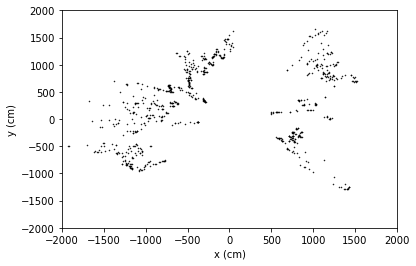

In [12]:
#=========== 1 picture ===========
path = Path("ml_dataset/106.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
plot_lidar_raw_fig(lidar_pos_x, lidar_pos_y)

# dbscan(lidar_data, arrow=True)

In [ ]:
#=========== All pictures ===========
# plot_and_save_all_plt()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

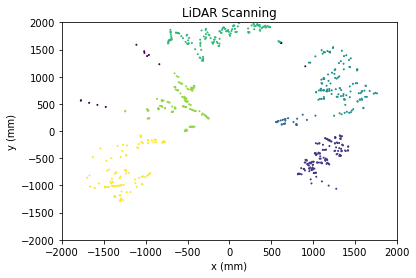

In [116]:
def get_function(x, y):
    a = (y[1] - y[0]) / (x[1] - x[0]) # 斜率
    b = y[0] - a * x[0] # 截距
    y_r = np.linspace(-1000, 1000, 4000) # TODO 有必要到4000那麼多嗎
    x_r = (y_r - b) / a
    return x_r, y_r # 回傳線段中的各點座標


def get_degree(x, y):
    try:
        a = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - a * x[0]
        y_0 = np.linspace(-1000, 1000, 4000)
        mid_dis = (0 - b) / a
        angle = np.rad2deg(np.arctan2(y[1] - y[0], x[0] - x[1]))
    except:
        a = 0
        b = 0
        angle = 0
        mid_dis = 0
    return angle, mid_dis


def dbscan(lidar_data, arrow=False):
    clustering = DBSCAN(algorithm='auto', eps=300, leaf_size=30, metric='euclidean',
        metric_params=None, min_samples=15, n_jobs=1, p=None)
    clustering = clustering.fit(lidar_data)
    label = clustering.labels_
    # print(f"label num = {max(label)}")

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(lidar_data[:,0], lidar_data[:,1], c=label, s=1)
    ax.set_xlim(left=-2000, right=2000)
    ax.set_ylim(bottom=-2000, top=2000)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_title('LiDAR Scanning')

    if arrow:
        wall = []
        x_data_array = []
        y_data_array = []
        obstacle_array = []
        x_0list = []
        y_0list = []
        x_0list_pca = []
        y_0list_pca = []
        average_x_data = []
        average_y_data = []
        x_mean_list= []
        label_array = []
        
        # TODO　應該可以簡化成不用雙迴圈
        # clustering 標籤類別
        for j in range(max(clustering.labels_) + 1):

            wall = []
            x_data_class_i = []
            x_data_array = [[]]
            y_data_class_i = []
            y_data_array = [[]]
            obstacle_array = []

            # 所有資料進行比對
            for i in range(len(lidar_data)):
                if clustering.labels_[i] == j:
                    xdata = lidar_data[:,0][i]
                    ydata = lidar_data[:,1][i]
                    label = clustering.labels_[i]

                    x_data_class_i.append(xdata)
                    y_data_class_i.append(ydata)
                    label_array.append(label)
            

            # TODO　改用離中心最近的cluster
            # average_x = np.mean(x_data_array)
            # x_min = min(x_data_array)
            # x_max = max(x_data_array)
            x_mean = np.mean(x_data_array)
            
            # y_min = min(y_data_array)
            # y_max = max(y_data_array)
            # y_mean = np.mean(y_data_array)

            # x_dis = np.abs((x_max - x_min))
            # y_dis = np.abs((y_max - y_min))
        
            # # 用Y預測X，因為需要在光達圖上繪製直線，可以限制在-1000~1000範圍內，如果是x預測當遇到直線前進時便會不好繪圖
            # x_0 = np.expand_dims(x_data_array, axis = 1)
            # y_0 = np.expand_dims(y_data_array, axis = 1)
            # model = LinearRegression()
            # model.fit(y_0, x_0)
            # predict_0 = model.predict(y_0)
            # x_0, y_0 = get_function(predict_0, y_0)
            # plt.plot(x_0, y_0, c = 'red')

            # x_0list.append(x_0)
            # y_0list.append(y_0)

            x_mean_list.append(x_mean)
        
        print(x_data_array)
        x_mean_list = np.array(x_mean_list)

        # 求出大於 1000 中最靠近 1000 的數的索引
        gt_indices = np.where(x_mean_list > 1000)[0]
        gt_min_index = np.argmin(np.abs(x_mean_list[gt_indices] - 1000))
        actual_gt_min_index = gt_indices[gt_min_index]

        # 求出小於 1000 中最靠近 1000 的數的索引
        lt_indices = np.where(x_mean_list < 1000)[0]
        lt_min_index = np.argmin(np.abs(x_mean_list[lt_indices] - 1000))
        actual_lt_min_index = lt_indices[lt_min_index]
        
        actual_min_index = [actual_gt_min_index, actual_lt_min_index]
        for i in actual_gt_min_index:
            model = LinearRegression()
            x_0 = np.expand_dims(x_data_array, axis=1)
            y_0 = np.expand_dims(y_data_array, axis=1)
            model.fit(y_0, x_0)
            predict_0 = model.predict(y_0)

            x_0, y_0 = get_function(predict_0, y_0)
            x_0list.append(x_0)
            y_0list.append(y_0)



        # Draw vertical line
        ax.vlines(x=0, ymin=-1000, ymax=1000, color = 'k', linewidth=2, linestyle='--')

        # CREATE reference line
        x_c = (x_0list[0] + x_0list[1]) / 2
        y_c = (y_0list[0] + y_0list[1]) / 2
        plt.arrow(x_c[0], y_c[0], x_c[-1]-x_c[0], y_c[-1]-y_c[0], head_length=100, head_width=100, color="blue")
        print('Linear Regression',90 - get_degree(x_c, y_c)[0], get_degree(x_c, y_c)[1])

    plt.text(x=-1750, y=-1750, s=f"number of clusters = {max(clustering.labels_) + 1}")
    plt.show()


path = Path("ml_dataset/115.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
dbscan(lidar_data, arrow=True)